## Dependencies

In [ ]:
import pandas as pd
import numpy as np

# import os
# import random
# import cv2

import numpy as np
# from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# import calendar
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# %matplotlib inline
# !pip install tensorflow
import time
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Conv1D, Flatten,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

# Regular Expression for text cleaning
import re
# to track the progress - progress bar
from tqdm.notebook import tqdm

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.utils import class_weight

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

Load already cleaned text.

In [2]:
# Change:
# News headlines dataset instead of reddit

df = pd.read_csv("/content/drive/MyDrive/Kaggle Club/SARCASM PROJECT '25/cleaned_NewsHeadlines_comments.csv").fillna(' ')
df = df.drop('article_link', axis=1)
df

,is_sarcastic,headline
0,1,thirtysomethe scientist unveil doomsday clock ...
1,0,dem rep totally nail why congress be fall shor...
2,0,eat your veggie 9 deliciously different recipe
3,1,inclement weather prevent liar get to work
4,1,mother come pretty close to use word streaming...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappoint consp...
28616,0,most beautiful acceptance speech this week com...
28617,1,mars probe destroy by orbit spielberg gates sp...


## Dataset split
Training/Validation/Test : 80/10/10

Constant seed = 42

In [3]:
strat = df['is_sarcastic']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['is_sarcastic']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)

print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (28619, 2)
Train shape is  (22895, 2)
Valid shape is  (2862, 2)
Test shape is  (2862, 2)


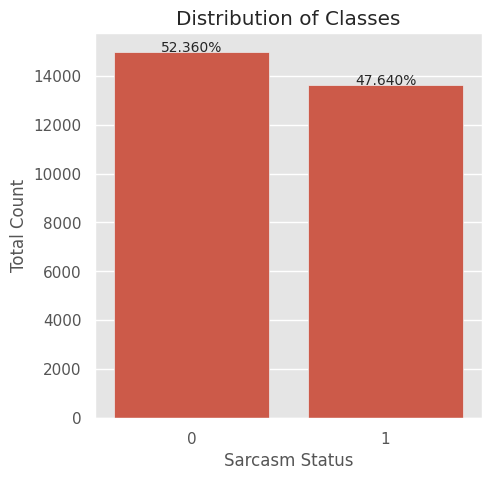

In [4]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='is_sarcastic',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format((height/total)*100),
            ha="center")
plt.show()

In [5]:
# X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)
y_train = train_df['is_sarcastic']
y_test = test_df['is_sarcastic']
X_train = train_df['headline']
X_test = test_df['headline']

## Tokenization + embedding

In [ ]:
MAX_LENGTH = 64  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of th

## Model

In [7]:
MAX_NUM_WORDS = len(tokenizer.get_vocab())

In [8]:
EMBEDDING_DIM = 128  # Word embedding size
LSTM_UNITS = 128

input_layer = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(LSTM_UNITS))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### CSV Logger (for training curves)

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping

# Define the CSVLogger callback
csv_logger = CSVLogger("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr23_BERT_BiLSTM_10epoch_News_Headlines_Adam_training_history.csv", append=True)  # Replace with desired path
def checkpoint_callback():
    checkpoint_filepath = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr23_BERT_BiLSTM_10epoch_News_Headlines_Adam_model.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                          #  save_weights_only=True,  # Save only the best weights
                           monitor='val_accuracy',
                           mode = 'max',          # 'max' because we are looking for max validation acc
                           save_best_only=True,
                           verbose=1)
    return model_checkpoint_callback
# ** no early stopping b/c it's 5 epochs. might try patience later based on training results.
checkpoint_callback = checkpoint_callback()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
callbacks = [checkpoint_callback, csv_logger, early_stopping]

bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = bi_lstm_model.fit(X_train_encoded['input_ids'], y_train,
                         validation_data=(X_test_encoded['input_ids'], y_test),
                         epochs=10, batch_size=64, class_weight=class_weight_dict,
                             callbacks=callbacks)

# pickle
import pickle
history_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr23_BERT_BiLSTM_10epoch_News_Headlines_Adam_model.pickle"
with open(history_path, 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)

Epoch 1/10
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6996 - loss: 0.5438
Epoch 1: val_accuracy improved from -inf to 0.83368, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr23_BERT_BiLSTM_10epoch_News_Headlines_Adam_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7002 - loss: 0.5431 - val_accuracy: 0.8337 - val_loss: 0.3655
Epoch 2/10
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8998 - loss: 0.2491
Epoch 2: val_accuracy did not improve from 0.83368
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8998 - loss: 0.2492 - val_accuracy: 0.8316 - val_loss: 0.3700
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9467 - loss: 0.1418
Epoch 3: val_accuracy did not improve from 0.83368
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9467 - loss: 0.1418 - val_accuracy: 0.8298 - val_loss: 0.4498
Epoch 4/10
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9667 - loss: 0.0923

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

class_names = [str(i) for i in range(len(np.unique(y_test)))]
y_pred = bi_lstm_model.predict(X_test_encoded['input_ids']) # Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int) # Get the true class labels from the test data generator

# Check if y_test is one-hot encoded or class labels
if len(y_test.shape) == 2:
    y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true_labels = y_test  # Already class labels

accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Testing Accuracy: 0.8200559049615653
Testing F1 Score: 0.8080506895266493
The Accuracy is 0.8200559049615653


In [11]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)
print("Classification Report: ")
print( report)

Classification Report: 
              precision    recall  f1-score   support

           0     0.8185    0.8431    0.8306      1498
           1     0.8218    0.7947    0.8081      1364

    accuracy                         0.8201      2862
   macro avg     0.8202    0.8189    0.8193      2862
weighted avg     0.8201    0.8201    0.8199      2862



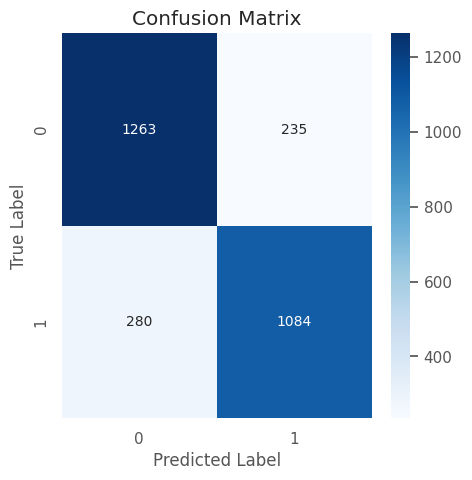

In [ ]:
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


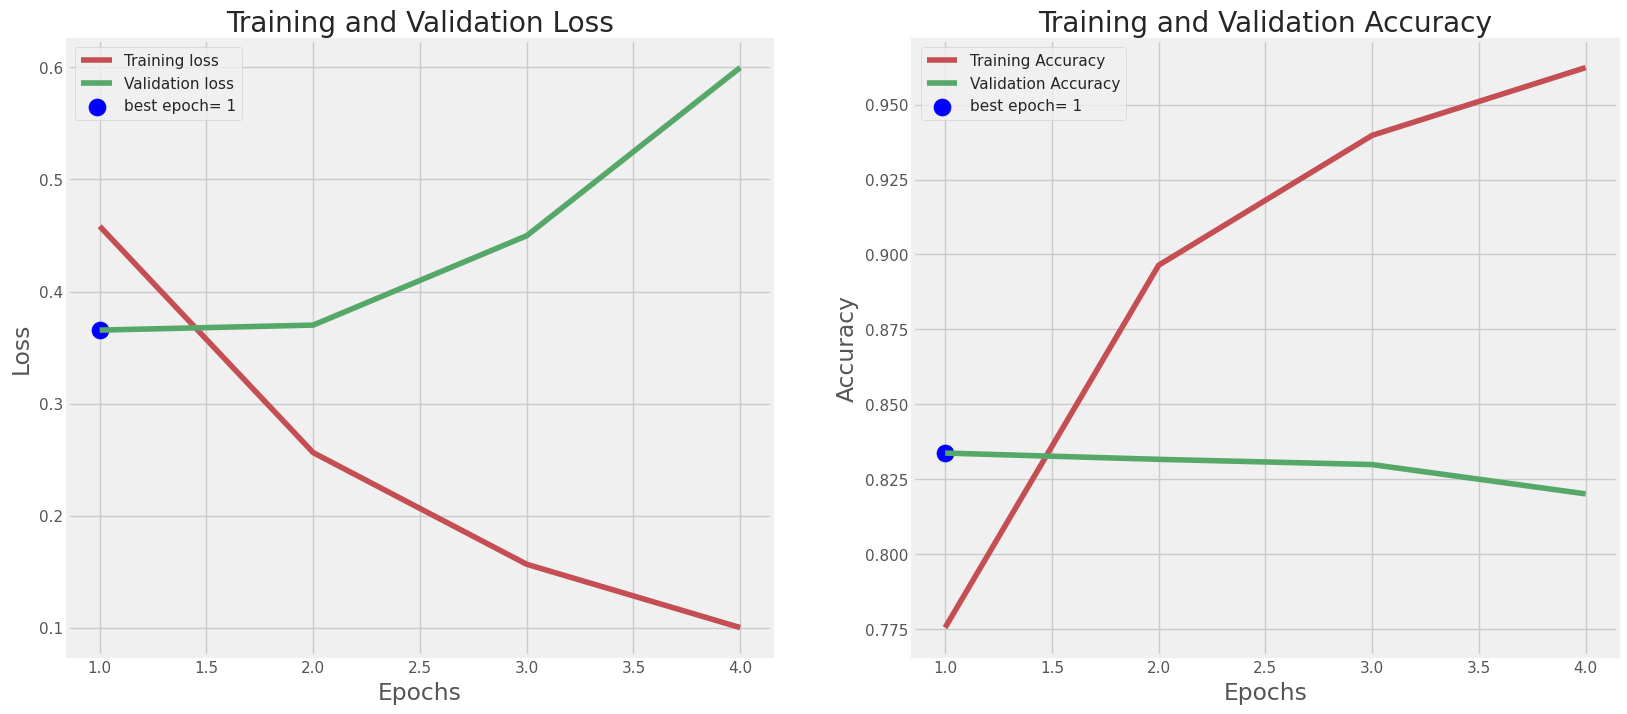

In [ ]:
# Function to get true and predicted labels from the dataset
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(hist)


## Preprocessing: Length Analysis (do not run)

Number of sequences: 28619
Minimum length: 1
Maximum length: 161
Average length: 10.87
Median length: 11.0
75th percentile length: 13.0
90th percentile length: 16.0
95th percentile length: 17.0
99th percentile length: 21.0


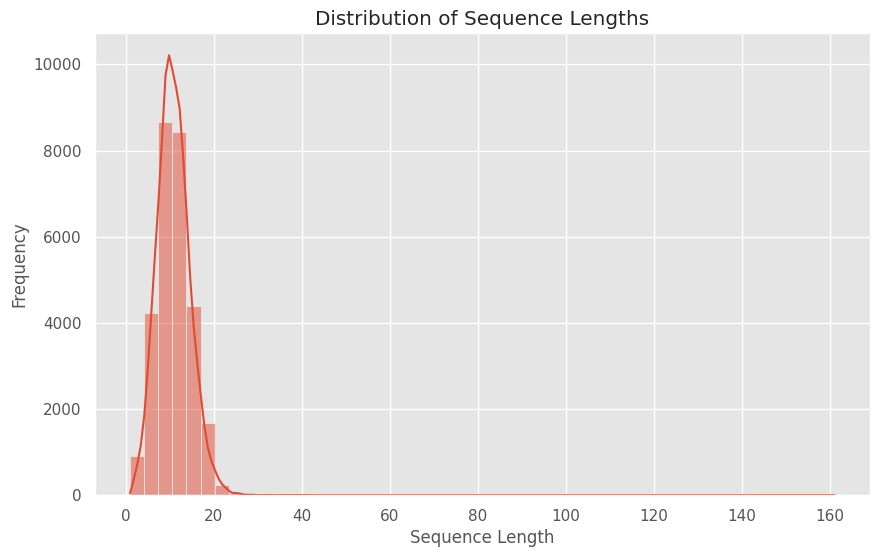

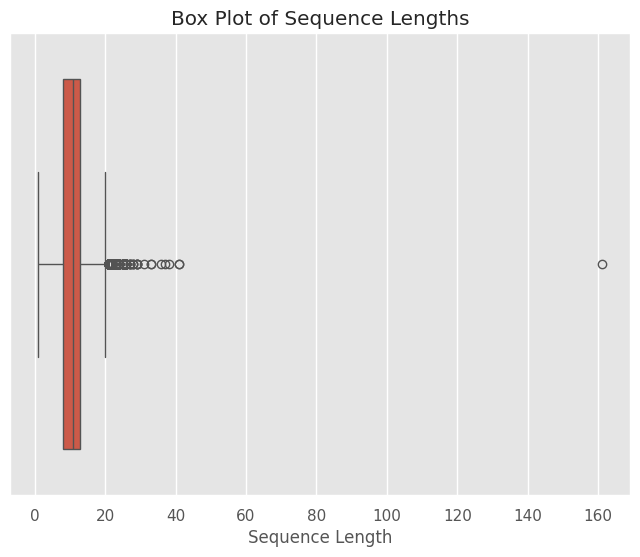


Percentage of data covered by different max_length values:
max_length = 64: 100.00% of sequences covered
max_length = 128: 100.00% of sequences covered
max_length = 256: 100.00% of sequences covered
max_length = 512: 100.00% of sequences covered

Based on the analysis:
- Consider a max_length that covers a high percentage of your data (e.g., 90-95%).
- Balance information retention with computational efficiency.
- Experiment with a few different max_length values during model training and validation.
- If using a Transformer model, be mindful of its maximum input length (e.g., 512 for BERT).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def analyze_sequence_lengths(texts, tokenizer=tokenizer, model_name='bert-base-uncased', max_length_options=None):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()

    if tokenizer is None:
        print("Using basic word split for length analysis. Consider providing a tokenizer for more accurate token-based lengths.")
        lengths = [len(text.split()) for text in texts]
    else:
        lengths = [len(tokenizer.encode(text, add_special_tokens=False)) for text in texts]

    print(f"Number of sequences: {len(lengths)}")
    print(f"Minimum length: {np.min(lengths)}")
    print(f"Maximum length: {np.max(lengths)}")
    print(f"Average length: {np.mean(lengths):.2f}")
    print(f"Median length: {np.median(lengths)}")
    print(f"75th percentile length: {np.percentile(lengths, 75)}")
    print(f"90th percentile length: {np.percentile(lengths, 90)}")
    print(f"95th percentile length: {np.percentile(lengths, 95)}")
    print(f"99th percentile length: {np.percentile(lengths, 99)}")

    # Visualize the distribution of lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=50, kde=True)
    plt.title("Distribution of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=lengths)
    plt.title("Box Plot of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.show()

    if max_length_options:
        print("\nPercentage of data covered by different max_length values:")
        for max_len in sorted(max_length_options):
            covered_count = sum(1 for length in lengths if length <= max_len)
            percentage = (covered_count / len(lengths)) * 100
            print(f"max_length = {max_len}: {percentage:.2f}% of sequences covered")

if __name__ == "__main__":
    texts = df['headline']

    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    except Exception as e:
        print(f"Warning: Could not load BERT tokenizer. Using basic word split. Error: {e}")
        tokenizer = None

    suggested_max_lengths = [64, 128, 256, 512]

    analyze_sequence_lengths(texts, tokenizer=tokenizer, max_length_options=suggested_max_lengths)

    print("\nBased on the analysis:")
    print("- Consider a max_length that covers a high percentage of your data (e.g., 90-95%).")
    print("- Balance information retention with computational efficiency.")
    print("- Experiment with a few different max_length values during model training and validation.")
    print("- If using a Transformer model, be mindful of its maximum input length (e.g., 512 for BERT).")